In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.2.1')

In [2]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

In [3]:
start_time = time.time()
all_features_2019 = pd.read_parquet(f"{SCRATCH_DIR}/all_features_2019.parquet")
end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

all_features_2019

Elapsed time: 36.7149 seconds


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginCityMarketID,...,TC-DATA-HOLDER,faa_registration_origin,Origin_DISPLAY_AIRPORT_NAME,Origin_DISPLAY_AIRPORT_CITY_NAME_FULL,Origin_LATITUDE,Origin_LONGITUDE,Dest_DISPLAY_AIRPORT_NAME,Dest_DISPLAY_AIRPORT_CITY_NAME_FULL,Dest_LATITUDE,Dest_LONGITUDE
24733033,2019,1,1,4,5,2019-01-04 00:00:00,OO,945SW,5657,34236,...,...,2023.0,San Luis County Regional,"San Luis Obispo, CA",35.237222,-120.642500,San Francisco International,"San Francisco, CA",37.618889,-122.375556
24733034,2019,1,1,4,5,2019-01-04 00:00:00,OO,932SW,5658,31453,...,...,2023.0,George Bush Intercontinental/Houston,"Houston, TX",29.984444,-95.341389,Northwest Arkansas National,"Fayetteville, AR",36.281667,-94.307778
24733035,2019,1,1,4,5,2019-01-04 00:00:00,OO,932SW,5658,34783,...,...,2023.0,Springfield-Branson National,"Springfield, MO",37.245556,-93.388611,George Bush Intercontinental/Houston,"Houston, TX",29.984444,-95.341389
24733036,2019,1,1,4,5,2019-01-04 00:00:00,OO,916SW,5659,32389,...,...,2023.0,Sloulin Field International,"Williston, ND",48.178056,-103.642222,Denver International,"Denver, CO",39.861667,-104.673056
24733037,2019,1,1,4,5,2019-01-04 00:00:00,OO,107SY,5660,33342,...,...,2023.0,General Mitchell International,"Milwaukee, WI",42.946944,-87.896944,Denver International,"Denver, CO",39.861667,-104.673056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288695,2019,4,12,1,7,2019-12-01 00:00:00,DL,346DN,830,30397,...,AIRBUS SAS ...,2023.0,Hartsfield-Jackson Atlanta International,"Atlanta, GA",33.636667,-84.427778,LaGuardia,"New York, NY",40.777222,-73.872500
32288696,2019,4,12,1,7,2019-12-01 00:00:00,DL,697DL,831,31454,...,...,2023.0,Orlando International,"Orlando, FL",28.429444,-81.308889,Minneapolis-St Paul International,"Minneapolis, MN",44.881944,-93.221667
32288697,2019,4,12,1,7,2019-12-01 00:00:00,DL,697DL,831,31650,...,...,2023.0,Minneapolis-St Paul International,"Minneapolis, MN",44.881944,-93.221667,Orlando International,"Orlando, FL",28.429444,-81.308889
32288698,2019,4,12,1,7,2019-12-01 00:00:00,DL,6714Q,832,30852,...,...,2023.0,Ronald Reagan Washington National,"Washington, DC",38.851389,-77.037778,Salt Lake City International,"Salt Lake City, UT",40.788333,-111.977778


In [4]:
united_df = all_features_2019[all_features_2019["Reporting_Airline"].eq("UA")].drop("Reporting_Airline", axis=1)

df = united_df[united_df["Cancelled"].eq(0) & united_df["Diverted"].eq(0)].copy()

df = df[df["Origin"].eq("ORD") | df["Dest"].eq("ORD")]

df["delayed"] = (df["DepDel15"].eq(1)) | (df["ArrDel15"].eq(1))

print(f"Removed {len(united_df) - len(df)} rows")

Removed 484833 rows


In [5]:
# Feature selection from "feature_selection_2019_UA-for-real.ipynb"

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "FlightDate",
    "Tail_Number",
    "Origin",
    "DestCityMarketID",
    "Dest",
    "N-NUMBER",
    "MFR MDL CODE",
    "ENG MFR MDL",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MODE S CODE",
    "MODE S CODE HEX",
    "CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "CODE_aircraft",
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    "BUILD-CERT-IND",
    "faa_registration_origin",
    "Origin_DISPLAY_AIRPORT_NAME",
    "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    "Dest_DISPLAY_AIRPORT_NAME",
    "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
]

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def preprocess_data(df):
    X = df.drop("delayed", axis=1)
    y = df["delayed"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(), cat_cols),
        ]
    )

    X_transformed = preprocessor.fit_transform(X)
    
    return X_transformed, y

In [7]:
from sklearn.linear_model import LogisticRegression


def fit_logistic_regression(X_train, y_train):
    logistic_regression = LogisticRegression(solver='saga', max_iter=1000)
    logistic_regression.fit(X_train, y_train)

    return logistic_regression

In [8]:
# Identify problematic columns
for col in num_cols:
    try:
        df[col].astype(float)
    except ValueError:
        print(f"Column {col} contains non-convertible values.")

Column YEAR MFR contains non-convertible values.


In [9]:
df["YEAR MFR"] = df["YEAR MFR"].replace(r'^\s*$', np.nan, regex=True)

df["YEAR MFR"].astype(float)

25272188    2001.0
25272196    2002.0
25272197    2015.0
25272202    2004.0
25272222    2004.0
             ...  
32219984    1994.0
32219989    2014.0
32219991    1999.0
32219994    2008.0
32219995    2004.0
Name: YEAR MFR, Length: 155218, dtype: float64

In [10]:
df_dropped_na = df[num_cols + cat_cols + ["delayed"]].copy()

df_dropped_na = df_dropped_na.dropna(how="any", axis="index")

print(f"Removed {len(df) - len(df_dropped_na)} rows")

df_dropped_na

Removed 858 rows


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,MFR_aircraft,MODEL_aircraft,TYPE-ENG,BUILD-CERT-IND,faa_registration_origin,Origin_DISPLAY_AIRPORT_NAME,Origin_DISPLAY_AIRPORT_CITY_NAME_FULL,Dest_DISPLAY_AIRPORT_NAME,Dest_DISPLAY_AIRPORT_CITY_NAME_FULL,delayed
25272188,1,1,22,2,1315,1932,257,1846,8,2001,...,BOEING,757-33N,5.0,0.0,2023.0,San Francisco International,"San Francisco, CA",Chicago O'Hare International,"Chicago, IL",True
25272196,1,1,22,2,1000,1144,164,733,3,2002,...,BOEING,737-700,5.0,0.0,2023.0,LaGuardia,"New York, NY",Chicago O'Hare International,"Chicago, IL",False
25272197,1,1,22,2,1430,1650,80,296,2,2015,...,BOEING,737-924ER,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",John Glenn Columbus International,"Columbus, OH",True
25272202,1,1,22,2,1011,1200,169,888,4,2004,...,BOEING,757-324,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",Denver International,"Denver, CO",True
25272222,1,1,22,2,1423,2024,241,1723,7,2004,...,BOEING,737-824,5.0,0.0,2023.0,San Diego International,"San Diego, CA",Chicago O'Hare International,"Chicago, IL",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32219984,4,12,28,6,1747,2014,207,1197,5,1994,...,AIRBUS INDUSTRIE,A320-232,5.0,0.0,2023.0,Miami International,"Miami, FL",Chicago O'Hare International,"Chicago, IL",True
32219989,4,12,28,6,0755,1049,174,925,4,2014,...,BOEING,737-924ER,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",George Bush Intercontinental/Houston,"Houston, TX",False
32219991,4,12,28,6,2324,0510,226,1739,7,1999,...,BOEING,737-824,5.0,0.0,2023.0,Portland International,"Portland, OR",Chicago O'Hare International,"Chicago, IL",False
32219994,4,12,28,6,0745,1145,180,1120,5,2008,...,BOEING,737-924ER,5.0,0.0,2023.0,Chicago O'Hare International,"Chicago, IL",Southwest Florida International,"Fort Myers, FL",False


In [11]:
from sklearn.model_selection import train_test_split

start_time = time.time()

X, y = preprocess_data(df_dropped_na)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = fit_logistic_regression(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 21.8121 seconds


In [12]:
with open(f"{SCRATCH_DIR}/08_logistic_regression_2019_ORD_UA.pkl", "wb") as f:
    pickle.dump(model, f)

In [18]:
# Trying a grid search to improve recall

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

start_time = time.time()

smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scorer = make_scorer(recall_score)

model = GridSearchCV(LogisticRegression(solver='saga', max_iter=1000), param_grid={}, scoring=scorer)

model.fit(X_train_res, y_train_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

model

Elapsed time: 1423.9185 seconds


GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='saga'),
             param_grid={}, scoring=make_scorer(recall_score))

In [19]:
with open(f"{SCRATCH_DIR}/08_GridSearchCV_2019_ORD_UA.pkl", "wb") as f:
    pickle.dump(model, f)

In [20]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

y_pred = model.predict(X_test)

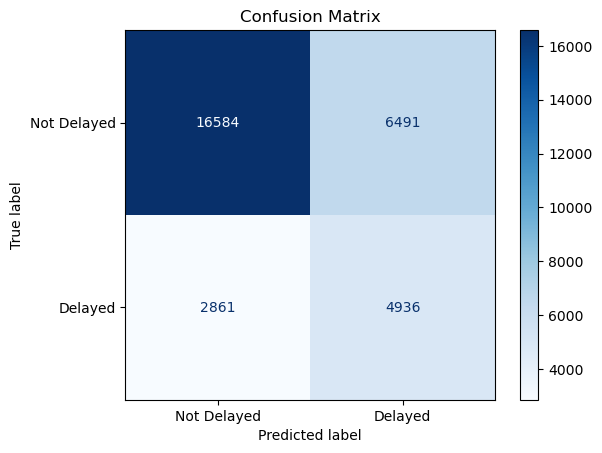

In [21]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

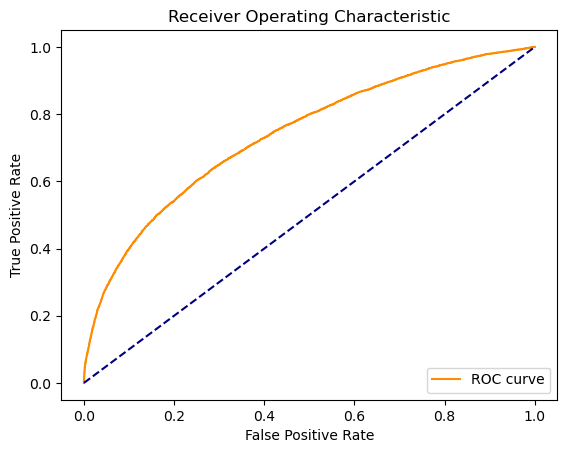

In [22]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

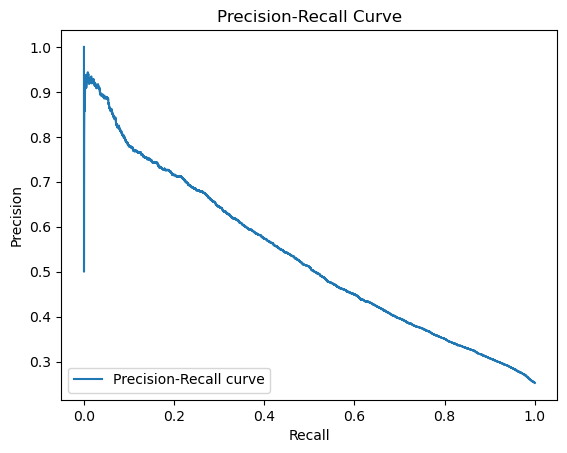

In [23]:
precision, recall, _ = precision_recall_curve(
    y_test, model.predict_proba(X_test)[:, 1]
)

plt.figure()
plt.plot(recall, precision, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_scores = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=['Metric', 'Score'])

fig = px.bar(df_metrics, 
             x='Score', 
             y='Metric', 
             orientation='h', 
             color='Metric', 
             text='Score',
             title='Evaluation Metrics')

fig.update_layout(showlegend=False)

fig.show()